In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

np.random.seed(1)

# YOLO-V3
推荐阅读：
- [How to implement a YOLO (v3) object detector from scratch in PyTorch: Part 1](https://blog.paperspace.com/how-to-implement-a-yolo-object-detector-in-pytorch)
- [史上最详细的Yolov3边框预测分析](https://zhuanlan.zhihu.com/p/49995236)
- [一文读懂YOLO V5 与 YOLO V4](https://zhuanlan.zhihu.com/p/161083602) 
- [a-PyTorch-Tutorial-to-Object-Detection](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection#a-detour)

## 1 A Fully Convolutional Neural Network
因为YOLO-V3仅使用卷积层，所以又称为完全卷积网络（FCN）。它具有75个卷积层，包括skip connections和upsampling layers；没有任何池化层（因为会造成low-level features丢失），而是使用`stride=2`的卷积层对特征图进行下采样。

尽管FCN不需要固定输入图像尺寸，但是由于各种潜在问题，我们还是希望固定输入图像尺寸。例如如果我们希望批处理图像（尤其GPU并行处理能大大提高速度），我们就需保证所有图像尺寸统一然后组成一个batch（concatenating many PyTorch tensors into one）。

## 2 Interpreting the output
通常，目标检测器将卷积层学习到的feature maps传递给分类器/回归器进行预测，包括边界框的坐标，类标签等。YOLO通过1x1卷积完成预测，因此最后的feature maps经过1x1卷积得到predication maps，两种maps的宽高一样，只是channel数不一样。如下图所示，predication maps中的每个cell的channels包括$B\times(5+C)$的信息，其中$B$表示这个cell预测的bound box数量（YOLO中设为3，即一个cell可以预测3个目标框）；$5$表示Box Coordinates（$t_x, t_y, t_w, t_h$）和Objectness Score（$p_0$）；$C$表示所有类别的Class Scores。

![](http://static.zybuluo.com/AustinMxnet/juhi4kgk0hmqlocby7vx8n6g/image.png)

只要一个目标的中心落在某个cell的receptive field中，这个cell的输出就包含这个目标。假设上图输入尺寸为416x416，网络最后输出的feature maps缩小了32倍变为13x13，我们可以将原图分为13x13个grid，于是图中狗的中心属于第7行第7列的grid，对应prediction maps的第7行和第7列上的cell，如果模型性能好，这个cell就应该输出狗的准确位置。

下面模拟一下网络的predication maps，大小为$13\times13$，每个cell预测$B=3$个框，物体种类$C=10$：

In [2]:
B = 3  # num of boxes
C = 10  # num of classes
output = torch.randn((13, 13, (B*(5+C))))

output.shape

torch.Size([13, 13, 45])

## 3 Anchor Boxes
YOLO中输出目标的bounding box为$t_x, t_y, t_w, t_h$，而不是直接输出$b_x, b_y, b_w, b_h$（中心x，中心y，宽w，高h），这是因为$b_x, b_y, b_w, b_h$变化太大，如果直接预测会导致训练时候梯度很不稳定。几乎所有目标检测器输出目标bounding box时都是预测其归一化的结果，YOLO的结果需要做如下转化：

$$\begin{aligned}
b_{x} &=\sigma\left(t_{x}\right)+c_{x} \\
b_{y} &=\sigma\left(t_{y}\right)+c_{y} \\
b_{w} &=p_{w} e^{t_{w}} \\
b_{h} &=p_{h} e^{t_{h}}
\end{aligned}$$

以下图为例，蓝色实线框是根据YOLO预测的$t_x,t_y,t_w,t_h$计算得到的目标框，蓝色点为$b_x, b_y$。**重点是黑色虚线的预设框，称为anchor**，为什么要有预设框？如果没有预设框anchor，那么网络需要直接预测目标形状和大小，而目标形状和大小变化范围太广，无疑给网络增加了学习的难度，并且导致训练不稳定。**个人认为这里的黑色框画的有些问题，因为黑色框中心在cell中心，所以应该围绕当前cell上下左右对称**，可以参见下文具体讨论anchor如何设置。而有预设框之后，网络只需要微调，即学习/预测目标框（蓝色实线框）和预设框（黑色虚线框）之间的偏移和缩放。其中：

- $c_x, c_y$为当前cell左上角（红色点）到原点距离（单位为grid），是直接计算出来的。例如下图中蓝色点所在cell的$c_x=1, c_y=1$；而上图红色cell的$c_x=6, c_y=6$。


- $\sigma()$为sigmoid激活函数，目的是为了将$t_x, t_y$限制在$[0, 1]$范围内，即$b_x, b_y$的范围限制在当前cell中。这点符合之前我们说的YOLO设计原则之一：每个cell预测中心落在这个cell对应grid中的目标。


- $p_w, p_h$为当前cell的预设框anchor（黑色虚线框）大小，是提前设置好的。


- ***重点！！！*** $e^{t_w}, e^{t_h}$是缩放比例。为什么要加个指数$e$呢？**这是因为缩放比例必须大于0，这是一个有不等式条件约束的优化问题，没法直接用SGD来优化，所以取指数变换后恒大于0，$t$的值就没有约束了**。

> 之前有个疑问，为什么要从grid左上角开始学习/预测和目标中心的偏移量，为什么不用grid中心也就是预设框anchor的中心？我猜测和$\sigma$函数有关系，$t_x/y$初始化为0时，$\sigma(0)=0.5$正好是当前cell的中心。

![](http://static.zybuluo.com/AustinMxnet/ktl4b6xtgdyqe8ygura4prfq/image.png)

anchors的大小是如何得到的呢？在YOLO-V3中是对数据集中所有目标框用K-Means分类后得到的，例如COCO数据集中对于13x13（原图416缩小了32倍）大小的feature maps中每个cell预设了三种，分别为`(116, 90), (156, 198), (373, 326)`，下面我们来看一下之前图中狗的中心$(7, 7)$画出来的预设框是怎样的：

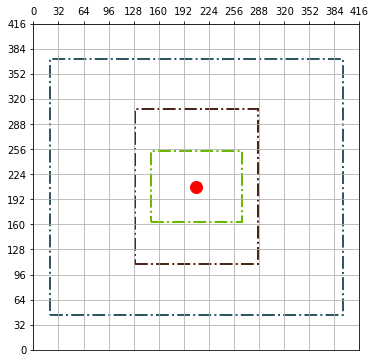

In [3]:
from matplotlib.patches import Rectangle


def plot_init_grid(ax, w=416, h=416, grid=13):
    ax.set_xticks(np.arange(0, w+1, w/grid))
    ax.set_yticks(np.arange(0, h+1, h/grid))
    ax.xaxis.tick_top()
    ax.set_aspect('equal')
    ax.invert_yaxis()


def plot_anchors(cx, cy, anchors):
    for w, h in anchors:
        xy = (cx-w/2., cy-h/2.)
        rect = Rectangle(xy, w, h, linewidth=2, fill=False, linestyle='-.',
                         edgecolor=np.random.rand(3,))
        ax.add_patch(rect)


# 图片尺寸
img_w = 416
img_h = 416
grid = 13

anchors = [(116, 90), (156, 198), (373, 326)]

plt.figure(figsize=(6, 6))
ax = plt.gca()
plot_init_grid(ax, img_w, img_h, grid)
plot_anchors(208, 208, anchors)
plt.plot(208, 208, '.r', markersize=24)

plt.xlim([0, img_w])
plt.ylim([0, img_h])

plt.grid()
plt.show()

结合下图左可以看出，三个预设框（蓝色）和目标框（黄色）匹配的还是很不错的（除了最小的预设框）。

![](http://static.zybuluo.com/AustinMxnet/clbyyn5hf9l0hzmfphfgjwhv/image.png)

但是有个问题：这只狗在图片中属于目标比较大的物体，如果目标很小，这三种预设框就不适合了（YOLO-V1把图片分为7x7个grids，而且还没anchor机制，所以小目标检测性能很不好）。如果我们在13x13的feature maps上增加anchor虽然有效果，但是13x13的feature maps中每个cell的感受野已经很大了，此时原图中很小的目标已经被缩放了32倍，在feature maps中占比很小，所以YOLO-V3引入了多尺度特征融合，并且在3个尺度上进行预测，新增的26x26和52x52尺度上的anchors见上图，网络结果如下图所示。

![](http://static.zybuluo.com/AustinMxnet/nfpcfozo42j6lwci8pad9ur0/image.png)

COCO数据集上经过K-Means计算得到的3类共9个anchors如下表所示，对于一个416x416的输入图像总共有13x13x3 + 26x26x3 + 52x52x3 = 10647个预测框（而YOLO-V2为13x13x5 = 845）。

![](http://static.zybuluo.com/AustinMxnet/pvh81wfa6g20rspsqcdkmrqt/image.png)

目标定位的损失函数为L2 loss，其中$l$表示网络预测的目标框与对应anchor框之间的偏移量，而$g$表示实际的目标框与anchor框之间的偏移量，所以预测的目标框和实际的目标框越接近，他们分别与anchor之间的偏移量$l, g$就会越接近：

$$L_{l o c}(l, g)=\sum_{i \in P} \sum_{m \in\{x, y, w, h\}}\left(\hat{l}_{i}^{m}-\hat{g}_{i}^{m}\right)^{2}$$

我们先看一下$l$是怎么计算的，$l$包括四个维度上的差距，分别是框中心坐标$x, y$和框宽高$w, h$。在本小节开头已经介绍过，$b^x, b^y, b^w, b^h$是预测框, $c^x, c^y, p^w, p^h$是对应的anchor。值得一提$b^x-c^x$和$b^y-c^y$已经被归一化了，范围不会超过一个grid：

$$\hat{l}_{i}^{x}=b_{i}^{x}-c_{i}^{x}, \quad \hat{l}_{i}^{y}=b_{i}^{y}-c_{i}^{y}$$

$$\hat{l}_{i}^{w}=\log \left(b_{i}^{w} / p_{i}^{w}\right), \quad \hat{l}_{i}^{h}=\log \left(b_{i}^{h} / p_{i}^{h}\right)$$

同理$g$就是实际的目标框$b^x, b^y, b^w, b^h$和对应anchor$c^x, c^y, p^w, p^h$之间的差距：

$$\hat{g}_{i}^{x}=g_{i}^{x}-c_{i}^{x}, \quad \hat{g}_{i}^{y}=g_{i}^{y}-c_{i}^{y}$$

$$\hat{g}_{i}^{w}=\log \left(g_{i}^{w} / p_{i}^{w}\right), \hat{g}_{i}^{h}=\log \left(g_{i}^{h} / p_{i}^{h}\right)$$

注意$L_{loc}$不需要计算所有的预测框，即$P$不等于anchors的个数，YOLO-V3都每个ground truth的目标只选一个最匹配的anchor，所以没被选中的anchor对应的预测框是不参与坐标和分类loss计算的。置于选哪一个anchor，就需要用到下面的Objectness Score了。

## 4 Objectness Score
之前我们说到每个cell除了输出预测框的大小和位置，还有一个Objectness Score，表示这个预测框是否有需要的目标。这个由sigmoid输出的概率，用于判断预测框是否有物体（IOU的Threshold=0.5）。***重点！！！*** 同一尺度下每个cell有三个anchor，其中Objectness Score最高的anchor才参与坐标和分类的loss计算，但是所有anchors都参与目标置信度loss计算。

$$S(x)=\frac{1}{1+e^{-x}}$$

sigmoid函数公式如上，输出范围为(0,1)。

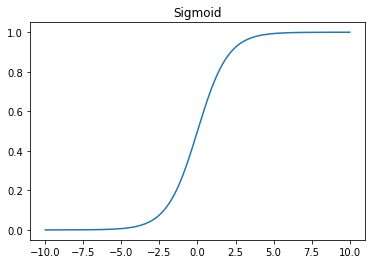

In [4]:
x = np.linspace(-10, 10, 1000)
y = 1/(1+np.exp(-x))

plt.plot(x, y)
plt.title('Sigmoid')
plt.show()

目标置信度Objectness Score的loss如下，$N$为预测框的个数，$o_i\in\{0，1\}表示框是否有效包含物体$：
$$
L_{\text{conf}}(o, c)=-\sum^\text{N}{\left(o_{i} \ln \left(\hat{c}_{i}\right)+\left(1-o_{i}\right) \ln \left(1-\hat{c}_{i}\right)\right)}
$$


$$\hat{c}_{i}=S\left(c_{i}\right)$$

## 5 Class Predication
YOLO-V3没有用softmax而是对每一类都用了逻辑回归（sigmoid为激活函数）进行预测，比较适合数据集中有交叉类的情况，例如Woman和Person。

因为逻辑回归为二分类，所以训练时候class predcitation的loss function就要用binary cross-entropy：

$$L_{cla}(o, c)=-\sum_{i \in P} \sum_{j \in M}\left(o_{ij} \ln \left(\hat{c}_{ij}\right)+\left(1-o_{ij}\right) \ln \left(1-\hat{c}_{i j}\right)\right)$$

其中$P$为真实目标的数量（之前我们说过每个真实目标只对应一个最好的anchor），$M$为目标的类别数。

## 6 Loss Function
$$L=\lambda_{1} L_{\text {conf}}(o, c)+\lambda_{2} L_{\text {cla}}(o_1, c_1)+\lambda_{3} L_{l o c}(l, g)$$

## 7 Darknet-53
![](http://static.zybuluo.com/AustinMxnet/ya5yy4v1e01w25x5a05ih0un/image.png)

YOLO-V3的主干网络是基于Darknet-53（如上图所示），只是把最后用于分类的层踢除，替换为预测bbox的网络，如下图：


![](http://static.zybuluo.com/AustinMxnet/1bmyr5iugbols4no4z0sophv/image.png)

## 8 YOLO-V3 Structure

![](http://static.zybuluo.com/AustinMxnet/gx6gy2jya234mlmadgqipw4k/image.png)

---
## 9 Backup

In [5]:
class BBox:
    def __init__(self, cx, cy, w, h):
        self.cx = cx  # center x
        self.cy = cy  # center y
        self.w = w  # width
        self.h = h  # height

    def mprect(self):
        """ return the bbox as the style of matplotlib Rectangle
        """
        # left-bottom (x, y)
        x = self.cx - self.w/2.
        y = self.cy - self.h/2.
        return (x, y), self.w, self.h

object_bbox = BBox(125, 160, 50, 60)

ax.add_patch(Rectangle(*object_bbox.mprect(), linewidth=2, fill=False,
                       edgecolor=np.random.rand(3,)))